In [ ]:
from transformers import BertModel, AutoTokenizer

from transformers import BertModel, AutoTokenizer

import torch

# load „bert-base-cased“ the pre-trained model

model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = False)

# load the corresponding wordtokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# example sentence

text = "Let’s deep dive into BERT."

# add [CLS] and [SEP] tokens

text = "[CLS]"+text.replace('.', '[SEP]')

# get tokens from the sentence

tokens = tokenizer.tokenize(

  text=text,

)

# set the maximum length of a sentence

max_length = 30

# add [PAD] tokens to shorter sentences

padded_tokens = tokens + ['[PAD]' for _ in range(max_length-len(tokens))]

# get token IDs

token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)

# generate the attention mask

attention_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]

# whether each token belongs to sentence A (0) or sentence B (1)

segment_ids = [0 for _ in range(len(padded_tokens))]

# convert lists to tensors

token_ids = torch.tensor(token_ids).unsqueeze(0)

attention_mask = torch.tensor(attention_mask).unsqueeze(0)

segment_ids = torch.tensor(segment_ids).unsqueeze(0)

#To retrieve the input embeddings extracted from the token IDs:

# get input embeddings

input_embeddings = model.embeddings(token_ids, token_type_ids=segment_ids)

In [ ]:
# set the model in evaluation mode

model.eval()

# get contextual embeddings

with torch.no_grad():

# output of shape <batch_size, max_length, embedding_size>

   last_hidden_states = model(token_ids, attention_mask=attention_mask, token_type_ids=segment_ids)["last_hidden_state"]

# first token embedding of shape <1, hidden_size>

first_token_embedding = last_hidden_states[:,0,:]

# pooled embedding of shape <1, hidden_size>

mean_pooled_embedding = last_hidden_states.mean(axis=1)

# In this section, we presented in detail how to generate text embeddings using BERT. For demonstration reasons, have manually added special tokens to our text. However, it’s possible to automate this pre-processing step in HuggingFace transformers library by making use of encode_plus function :

# encode the sentence

encoded = tokenizer.encode_plus(

  text='hi im vikas thakur',

  add_special_tokens=True,  # add [CLS] and [SEP] tokens

  max_length = 30,  # set the maximum length of a sentence

truncation = True,  # truncate longer sentences to max_length

padding='max_length',  # add [PAD] tokens to shorter sentences

return_attention_mask = True,  # generate the attention mask

return_tensors = 'pt',  # return encoding results as PyTorch tensors

)

# get the token IDs and attention mask

token_ids = encoded['input_ids']

attention_mask = encoded['attention_mask']

In [ ]:
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
# The error suggests an issue with delimiters.
# Try setting the delimiter to tab ('\t') to handle potential TSV files or
# use a more flexible delimiter with a regular expression.
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text']) # Added header=None and names to handle files without headers
print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()  # Set the model to evaluation mode

# Step 4: Extract features using BERT
features = []

for sentence in text_data:
    if sentence.strip():  # Skip empty sentences
        # Tokenize the input text
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512)

        # Get BERT outputs without gradients (to save memory and processing power)
        with torch.no_grad():
            outputs = model(**inputs)

        # Use mean pooling to get a single vector for the sentence
        sentence_embedding = torch.mean(outputs.last_hidden_state, dim=1)

        # Append the embedding to the list
        features.append(sentence_embedding)

# Stack all the embeddings into a single tensor
features = torch.vstack(features)  # Shape: (num_sentences, hidden_size)

# Step 5: Save the extracted features
# Convert to NumPy array
features_numpy = features.numpy()

# Save the features as a .npy file
np.save('bert_features.npy', features_numpy)

# Optionally, save the features as a .csv file
df_features = pd.DataFrame(features_numpy)
df_features.to_csv('bert_features.csv', index=False)

print('Features extracted and saved successfully.')

Saving Ses05F_impro01.txt to Ses05F_impro01.txt
File uploaded: Ses05F_impro01.txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Features extracted and saved successfully.


In [ ]:
from transformers import pipeline

# Define the BERT model checkpoint
checkpoint = "bert-base-uncased"

# Initialize the feature extraction pipeline
feature_extractor = pipeline("feature-extraction", framework="pt", model=checkpoint)

# Define the text
text = "vikas tahkur is a student of hptu"

# Extract features
features = feature_extractor(text, return_tensors="pt")[0]

# Convert to numpy array and reduce along the first dimension
reduced_features = features.numpy().mean(axis=0)

print(reduced_features)


[ 2.03841105e-01 -2.00066388e-01 -9.45809335e-02 -1.86023459e-01
  4.46514279e-01 -2.14571238e-01 -8.09868425e-02  3.45490009e-01
 -2.13179335e-01  2.12541834e-01  6.89556673e-02 -3.37328464e-01
 -1.91348106e-01  6.28071785e-01  3.41379344e-01  2.64963448e-01
  1.84348717e-01 -1.00835510e-01 -2.50376284e-01  2.96900630e-01
 -3.10031720e-03 -8.60301629e-02  2.09960014e-01  2.99712121e-01
  2.54928648e-01  3.33887458e-01  1.91524133e-01  6.08372211e-01
 -1.29314773e-02  3.24299753e-01 -1.83759555e-01  1.40547037e-01
 -2.84066319e-01 -1.67208254e-01 -7.73057118e-02 -1.67112559e-01
 -2.86748111e-01  9.57306251e-02 -4.29515429e-02  2.15323865e-02
 -4.29207653e-01 -6.54345453e-01 -7.65580833e-02 -5.82642779e-02
 -2.36476421e-01 -3.65227520e-01  1.64683655e-01  8.49739369e-03
 -3.13503325e-01 -2.50840820e-02 -6.80980384e-02  2.70718634e-01
  1.14413276e-01 -4.17036176e-01  1.96078211e-01  6.75541759e-01
 -7.63334259e-02 -9.65285972e-02 -5.72198853e-02 -9.57107395e-02
  4.30624962e-01  7.20506

In [ ]:
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
# The error suggests an issue with delimiters.
# Try setting the delimiter to tab ('\t') to handle potential TSV files or
# use a more flexible delimiter with a regular expression.
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text']) # Added header=None and names to handle files without headers
print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name,output_attentions=True)
model.eval()  # Set the model to evaluation mode

# Step 4: Extract features using BERT
features = []

for sentence in text_data:
    if sentence.strip():
        # Tokenize the input text
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512,padding='max_length')

        # Get BERT outputs without gradients
        with torch.no_grad():
            outputs = model(**inputs)

        # Use CLS token for sentence embedding
        sentence_embedding = outputs.pooler_output

        # Extract attention scores (optional)
        attention_scores = outputs.attentions[-1]  # Last layer's attention

        # Append embedding and attention scores to the list
        features.append((sentence_embedding, attention_scores))

# Stack embeddings and attention scores into separate tensors
embeddings = torch.vstack([feature[0] for feature in features]).squeeze(1)
attention_scores = torch.stack([feature[1] for feature in features])

# Step 5: Save the extracted features
# Convert to NumPy array
embeddings_numpy = embeddings.numpy()
attention_scores_numpy = attention_scores.numpy()

# Save the features as .npy files
np.save('bert_embeddings.npy', embeddings_numpy)
np.save('bert_attention_scores.npy', attention_scores_numpy)

# Optionally, save the features as .csv files
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('bert_embeddings.csv', index=False)

df_attention_scores = pd.DataFrame(attention_scores_numpy)
df_attention_scores.to_csv('bert_attention_scores.csv', index=False)

print('Features extracted and saved successfully.')

Saving Ses05F_impro01.txt to Ses05F_impro01.txt
File uploaded: Ses05F_impro01.txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


ValueError: Must pass 2-d input. shape=(50, 1, 12, 512, 512)

In [ ]:
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
# The error suggests an issue with delimiters.
# Try setting the delimiter to tab ('\t') to handle potential TSV files or
# use a more flexible delimiter with a regular expression.
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text']) # Added header=None and names to handle files without headers
print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name,output_attentions=True)
model.eval()  # Set the model to evaluation mode

# Step 4: Extract features using BERT
features = []

for sentence in text_data:
    if sentence.strip():
        # Tokenize the input text
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512,padding='max_length')

        # Get BERT outputs without gradients
        with torch.no_grad():
            outputs = model(**inputs)

        # Use CLS token for sentence embedding
        sentence_embedding = outputs.pooler_output

        # Extract attention scores (optional)
        attention_scores = outputs.attentions[-1]  # Last layer's attention

        # Append embedding and attention scores to the list
        features.append((sentence_embedding, attention_scores))

# Stack embeddings and attention scores into separate tensors
embeddings = torch.vstack([feature[0] for feature in features]).squeeze(1)
attention_scores = torch.stack([feature[1] for feature in features])

# Step 5: Save the extracted features
# Convert to NumPy array
embeddings_numpy = embeddings.numpy()
attention_scores_numpy = attention_scores.numpy()


# Save the features as .npy files
np.save('bert_embeddings.npy', embeddings_numpy)


# Optionally, save the features as .csv files
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('bert_embeddings.csv', index=False)



for i, sentence_attention in enumerate(attention_scores_numpy):
    for j, layer_attention in enumerate(sentence_attention):
        for k, head_attention in enumerate(layer_attention):
          flattened_attention = head_attention.flatten()

          df_attention = pd.DataFrame(flattened_attention, columns=['attention_score'])
          df_attention['sentence'] = i
          df_attention['layer'] = j
          df_attention['head'] = k


          df_attention.to_csv(f'attention_sentence_{i}_layer_{j}_head_{k}.csv', index=False)
          print('Features extracted and saved successfully.')






Saving Ses05F_impro01.txt to Ses05F_impro01.txt
File uploaded: Ses05F_impro01.txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features extracted and saved successfully.
Features ex

In [ ]:
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text']) # Added header=None and names to handle files without headers
print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()  # Set the model to evaluation mode

# Step 4: Extract BERT features
features = []

for sentence in text_data:
    if sentence.strip():
        # Tokenize the input text
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512, padding='max_length')

        # Get BERT outputs without gradients
        with torch.no_grad():
            outputs = model(**inputs)

        # Use CLS token for sentence embedding
        sentence_embedding = outputs.pooler_output

        # Extract attention scores (optional)
        attention_scores = outputs.attentions[-1]  # Last layer's attention

        # Append embedding and attention scores to the list
        features.append((sentence_embedding, attention_scores))

# Stack embeddings and attention scores into separate tensors
embeddings = torch.vstack([feature[0] for feature in features]).squeeze(1)
attention_scores = torch.stack([feature[1] for feature in features])

# Step 5: Extract TF-IDF features
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Convert TF-IDF matrix to NumPy array
tfidf_features = tfidf_matrix.toarray()

# Step 6: Combine features
# Combine BERT embeddings with TF-IDF features
combined_features = np.concatenate([embeddings_numpy, tfidf_features], axis=1)

# Step 7: Save features
# Save the combined features as a NumPy array
np.save('bert_tfidf_features.npy', combined_features)

# Optionally, save the features as CSV files (for embeddings and TF-IDF separately)
# ... (save embeddings as before)

# Save TF-IDF features
df_tfidf = pd.DataFrame(tfidf_features)
df_tfidf.to_csv('tfidf_features.csv', index=False)

print('Features extracted and saved successfully.')

Saving Ses05F_impro01.txt to Ses05F_impro01 (4).txt
File uploaded: Ses05F_impro01 (4).txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...
Features extracted and saved successfully.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
df=pd.read_csv("bert_embeddings.csv")

In [ ]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
45,-0.780274,-0.349589,-0.912259,0.704376,0.546997,-0.178727,0.619438,0.077815,-0.686194,-0.999924,...,0.583030,0.130372,0.900874,0.711102,0.016777,0.127667,0.667971,-0.882841,-0.626608,0.789167
46,-0.797466,-0.232165,-0.812638,0.671517,0.533950,-0.072187,0.674309,0.204465,-0.632869,-0.999919,...,0.517115,0.234003,0.868127,0.709863,-0.406719,0.079530,0.615386,-0.746522,-0.563874,0.792374
47,-0.598384,-0.316972,-0.839115,0.616758,0.498015,0.003600,0.406987,0.170750,-0.655559,-0.999910,...,0.622550,0.118855,0.779093,0.654131,0.067575,0.047693,0.705840,-0.658331,-0.580160,0.719372
48,-0.812769,-0.256613,-0.852946,0.693976,0.435692,-0.064883,0.736843,0.190819,-0.716854,-0.999954,...,0.620762,-0.153802,0.887163,0.786979,-0.373553,-0.040429,0.648820,-0.824070,-0.504436,0.735514
49,-0.811599,-0.342237,-0.902629,0.695379,0.476669,-0.052466,0.674612,0.131137,-0.781295,-0.999979,...,0.532882,-0.282039,0.962124,0.825305,0.088611,0.282433,0.617799,-0.730952,-0.701085,0.762614


In [ ]:
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel # Removed util
from sentence_transformers import SentenceTransformer # Added this line to import SentenceTransformer from the correct library
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text']) # Added header=None and names to handle files without headers
print(df.head()) # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
# model_name = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertModel.from_pretrained(model_name, output_attentions=True)
# model.eval()  # Set the model to evaluation mode

# Use a pre-trained sentence transformer for reduced dimensionality
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

# Step 4: Extract BERT features
embeddings = model.encode(text_data, convert_to_tensor=True)

# Step 5: Extract TF-IDF features
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Select top 100 features

# Fit the vectorizer to the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Convert TF-IDF matrix to NumPy array
tfidf_features = tfidf_matrix.toarray()

# Step 6: Combine features
# Concatenate only a subset of TF-IDF features with BERT embeddings
relevant_tfidf_features = tfidf_features[:, 20:36]  # Assuming indices 20-35 are relevant
combined_features = np.concatenate([embeddings, relevant_tfidf_features], axis=1)

# Step 7: Save features
# Save the combined features as a NumPy array
np.save('bert_tfidf_features.npy', combined_features)

# Optionally, save the features as CSV files (for embeddings and TF-IDF separately)
# ... (save embeddings as before)

# Save TF-IDF features
df_tfidf = pd.DataFrame(tfidf_features)
df_tfidf.to_csv('tfidf_features.csv', index=False)

print('Features extracted and saved successfully.')

Saving Ses05F_impro01.txt to Ses05F_impro01 (1).txt
File uploaded: Ses05F_impro01 (1).txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Features extracted and saved successfully.


In [ ]:
import pandas as pd
df=pd.read_csv("tfidf_features.csv")

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.519406,0.0,...,0.0,0.0,0.0,0.240213,0.0,0.0,0.0,0.259703,0.259703,0.202959
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.225688,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.095344


In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()  # Set the model to evaluation mode

# Step 4: Extract BERT features (reduced size)
features = []

for sentence in text_data:
    if sentence.strip():
        # Tokenize the input text
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512, padding='max_length')

        # Get BERT outputs without gradients
        with torch.no_grad():
            outputs = model(**inputs)

            # Use only the CLS token embedding (sentence representation)
            sentence_embedding = outputs.pooler_output

        features.append(sentence_embedding)

# Stack embeddings into a single tensor
embeddings = torch.vstack(features).squeeze(1)

# Step 5: Save the extracted features (reduced dimensionality)
embeddings_numpy = embeddings.numpy()
np.save('bert_embeddings.npy', embeddings_numpy)  # Saves just sentence embeddings

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('bert_embeddings22.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

Saving Ses05F_impro01.txt to Ses05F_impro01 (1).txt
File uploaded: Ses05F_impro01 (1).txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Features extracted and saved successfully (reduced size).


In [ ]:
import pandas as pd
df=pd.read_csv("bert_embeddings22.csv")

In [ ]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
45,-0.780276,-0.349590,-0.912260,0.704378,0.546998,-0.178728,0.619442,0.077816,-0.686195,-0.999924,...,0.583031,0.130370,0.900875,0.711104,0.016776,0.127666,0.667972,-0.882841,-0.626609,0.789168
46,-0.797466,-0.232165,-0.812638,0.671518,0.533950,-0.072187,0.674310,0.204465,-0.632869,-0.999919,...,0.517116,0.234002,0.868127,0.709864,-0.406719,0.079531,0.615387,-0.746522,-0.563874,0.792375
47,-0.598384,-0.316971,-0.839114,0.616758,0.498014,0.003600,0.406988,0.170750,-0.655558,-0.999910,...,0.622550,0.118855,0.779092,0.654131,0.067576,0.047694,0.705840,-0.658330,-0.580160,0.719372
48,-0.812769,-0.256613,-0.852946,0.693977,0.435693,-0.064883,0.736844,0.190819,-0.716854,-0.999954,...,0.620763,-0.153802,0.887163,0.786980,-0.373553,-0.040428,0.648821,-0.824070,-0.504436,0.735514
49,-0.811599,-0.342237,-0.902629,0.695380,0.476670,-0.052466,0.674613,0.131137,-0.781296,-0.999979,...,0.532882,-0.282040,0.962124,0.825305,0.088610,0.282433,0.617800,-0.730952,-0.701086,0.762614


In [ ]:
!pip install sentence-transformers
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, SentenceTransformer, util
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'all-mpnet-base-v2'  # Use a pre-trained sentence transformer
model = SentenceTransformer(model_name)

# Step 4: Extract BERT features (reduced dimensionality)
embeddings = model.encode(text_data, convert_to_tensor=True)

# Step 5: Reduce dimensionality further (optional)
# Apply PCA to reduce the dimensionality of embeddings
pca = PCA(n_components=128)  # Adjust n_components as needed
embeddings_reduced = pca.fit_transform(embeddings)

# Step 6: Save the extracted features (reduced size)
embeddings_numpy = embeddings_reduced  # Use the reduced embeddings
np.save('bert_embeddings_reduced.npy', embeddings_numpy)

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('bert_embeddings_reduced.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

ImportError: cannot import name 'SentenceTransformer' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [ ]:
!pip install sentence-transformers # Make sure to install sentence-transformers
from sentence_transformers import SentenceTransformer, util # Import SentenceTransformer and util from sentence_transformers
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'all-mpnet-base-v2'  # Use a pre-trained sentence transformer
model = SentenceTransformer(model_name)

# Step 4: Extract BERT features (reduced dimensionality)
embeddings = model.encode(text_data, convert_to_tensor=True)

# Step 5: Reduce dimensionality further (optional)
# Apply PCA to reduce the dimensionality of embeddings
pca = PCA(n_components=128)  # Adjust n_components as needed
embeddings_cpu = embeddings.cpu()

embeddings_reduced = pca.fit_transform(embeddings_cpu)

# Step 6: Save the extracted features (reduced size)
embeddings_numpy = embeddings_reduced  # Use the reduced embeddings
np.save('bert_embeddings_reduced.npy', embeddings_numpy)

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('bert_embeddings_reduced.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

Saving Ses05F_impro01.txt to Ses05F_impro01 (3).txt
File uploaded: Ses05F_impro01 (3).txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ValueError: n_components=128 must be between 0 and min(n_samples, n_features)=50 with svd_solver='full'

In [ ]:
 # Make sure to install sentence-transformers
from sentence_transformers import SentenceTransformer, util # Import SentenceTransformer and util from sentence_transformers
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Initialize BERT tokenizer and model
model_name = 'all-mpnet-base-v2'  # Use a pre-trained sentence transformer
model = SentenceTransformer(model_name)

# Step 4: Extract BERT features (reduced dimensionality)
embeddings = model.encode(text_data, convert_to_tensor=True)

# Step 5: Reduce dimensionality further (optional)
# Apply PCA to reduce the dimensionality of embeddings
pca = PCA(n_components=50)  # Adjust n_components to be <= the number of samples
embeddings_cpu = embeddings.cpu()

embeddings_reduced = pca.fit_transform(embeddings_cpu)

# Step 6: Save the extracted features (reduced size)
embeddings_numpy = embeddings_reduced  # Use the reduced embeddings
np.save('bert_embeddings_reduced.npy', embeddings_numpy)

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('bert_embeddings_reduced.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

Saving Ses05F_impro01.txt to Ses05F_impro01 (4).txt
File uploaded: Ses05F_impro01 (4).txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Features extracted and saved successfully (reduced size).


In [ ]:
import pandas as pd
data=pd.read_csv("bert_embeddings_reduced.csv")

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.113570,-0.301222,-0.012186,-0.203515,-0.045677,0.278025,-0.026745,0.137062,-0.165799,0.064590,...,-0.013653,-0.025892,0.021330,0.018196,-0.008755,-0.006287,0.002847,0.019607,0.009386,1.166352e-16
1,-0.150142,-0.021622,-0.183929,0.082390,0.375247,-0.080308,0.020740,0.140873,0.158287,0.030348,...,0.005402,0.011662,0.056218,0.002394,-0.029074,-0.019524,-0.004840,-0.026829,0.007604,1.166352e-16
2,-0.482647,-0.076297,0.353324,0.017658,-0.058868,-0.008008,0.106331,-0.277339,-0.154712,0.181830,...,0.060241,-0.051482,0.007085,0.013301,0.000453,0.034670,-0.041100,-0.038405,-0.096957,1.166352e-16
3,0.366922,0.058965,0.141161,-0.175118,-0.041659,-0.064318,0.156747,0.026119,0.090685,0.123775,...,-0.022044,0.012188,-0.067674,0.056275,-0.023971,0.000949,0.008139,-0.005079,-0.003725,1.166352e-16
4,0.128046,-0.230469,-0.098164,-0.116729,0.185835,0.036109,-0.100447,0.070634,-0.216191,-0.105954,...,-0.002004,0.006048,-0.036039,-0.019195,0.021680,-0.031726,-0.014572,-0.016745,0.009336,1.166352e-16


In [ ]:
!pip install sentence-transformers
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel, SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Preprocess text data for word embeddings
sentences = [sentence.split() for sentence in text_data]

# Step 4: Train Word2Vec model (if not using pre-trained)
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Step 5: Extract word embeddings and average for each sentence
sentence_embeddings = []
for sentence in sentences:
    word_embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if word_embeddings:
        sentence_embedding = np.mean(word_embeddings, axis=0)
        sentence_embeddings.append(sentence_embedding)

# Step 6: Combine with BERT embeddings (optional)
bert_embeddings = model.encode(text_data, convert_to_tensor=True)
combined_embeddings = np.concatenate([sentence_embeddings, bert_embeddings], axis=1)

# Step 7: Reduce dimensionality (optional)
# Apply PCA to reduce the dimensionality of combined embeddings
pca = PCA(n_components=128)  # Adjust n_components as needed
combined_embeddings_reduced = pca.fit_transform(combined_embeddings)

# Step 8: Save the extracted features (reduced size)
embeddings_numpy = combined_embeddings_reduced  # Use the reduced combined embeddings
np.save('combined_embeddings_reduced.npy', embeddings_numpy)

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('combined_embeddings_reduced.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

ImportError: cannot import name 'SentenceTransformer' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [ ]:
!pip install sentence-transformers
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel # Remove SentenceTransformer from this import statement
from sentence_transformers import SentenceTransformer # Import SentenceTransformer from sentence_transformers
import numpy as np
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Preprocess text data for word embeddings
sentences = [sentence.split() for sentence in text_data]

# Step 4: Train Word2Vec model (if not using pre-trained)
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Step 5: Extract word embeddings and average for each sentence
sentence_embeddings = []
for sentence in sentences:
    word_embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if word_embeddings:
        sentence_embedding = np.mean(word_embeddings, axis=0)
        sentence_embeddings.append(sentence_embedding)

# Step 6: Combine with BERT embeddings (optional)
# You might need to reinitialize this based on your requirements
model = SentenceTransformer('all-mpnet-base-v2') # Initialize sentence transformer model
bert_embeddings = model.encode(text_data, convert_to_tensor=True)

combined_embeddings = np.concatenate([sentence_embeddings, bert_embeddings], axis=1)

# Step 7: Reduce dimensionality (optional)
# Apply PCA to reduce the dimensionality of combined embeddings
pca = PCA(n_components=128)  # Adjust n_components as needed
combined_embeddings_reduced = pca.fit_transform(combined_embeddings)

# Step 8: Save the extracted features (reduced size)
embeddings_numpy = combined_embeddings_reduced  # Use the reduced combined embeddings
np.save('combined_embeddings_reduced.npy', embeddings_numpy)

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('combined_embeddings_reduced.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

Saving Ses05F_impro01.txt to Ses05F_impro01 (6).txt
File uploaded: Ses05F_impro01 (6).txt
                                                text
0  Ses05F_impro01_F000 [003.6132-006.1700]: Hi, I...
1  Ses05F_impro01_M000 [005.7800-014.7800]: ahh Y...
2       Ses05F_impro01_FXX0 [013.0388-013.8112]: No.
3  Ses05F_impro01_F001 [014.1500-019.4900]: Okay,...
4  Ses05F_impro01_M001 [017.6400-024.1600]: I mea...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
!pip install sentence-transformers
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel # Remove SentenceTransformer from this import statement
from sentence_transformers import SentenceTransformer # Import SentenceTransformer from sentence_transformers
import numpy as np
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Preprocess text data for word embeddings
sentences = [sentence.split() for sentence in text_data]

# Step 4: Train Word2Vec model (if not using pre-trained)
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Step 5: Extract word embeddings and average for each sentence
sentence_embeddings = []
for sentence in sentences:
    word_embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if word_embeddings:
        sentence_embedding = np.mean(word_embeddings, axis=0)
        sentence_embeddings.append(sentence_embedding)

# Step 6: Combine with BERT embeddings (optional)
# You might need to reinitialize this based on your requirements
model = SentenceTransformer('all-mpnet-base-v2') # Initialize sentence transformer model
bert_embeddings = model.encode(text_data, convert_to_tensor=True)

# Move bert_embeddings to CPU
bert_embeddings = bert_embeddings.cpu()

combined_embeddings = np.concatenate([sentence_embeddings, bert_embeddings], axis=1)

# Step 7: Reduce dimensionality (optional)
# Apply PCA to reduce the dimensionality of combined embeddings
pca = PCA(n_components=50)  # Adjust n_components as needed
combined_embeddings_reduced = pca.fit_transform(combined_embeddings)

# Step 8: Save the extracted features (reduced size)
embeddings_numpy = combined_embeddings_reduced  # Use the reduced combined embeddings
np.save('combined_embeddings_reduced.npy', embeddings_numpy)

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('combined_embeddings_reduced.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

Saving _Ses01F_impro01_F000.txt to _Ses01F_impro01_F000 (1).txt
Saving _Ses01F_impro01_F001.txt to _Ses01F_impro01_F001 (1).txt
Saving _Ses01F_impro01_F002.txt to _Ses01F_impro01_F002 (1).txt
Saving _Ses01F_impro01_F003.txt to _Ses01F_impro01_F003 (1).txt
Saving _Ses01F_impro01_F004.txt to _Ses01F_impro01_F004 (1).txt
File uploaded: _Ses01F_impro01_F000 (1).txt


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 37: invalid start byte

NameError: name 'data_2d' is not defined

<Figure size 1000x600 with 0 Axes>

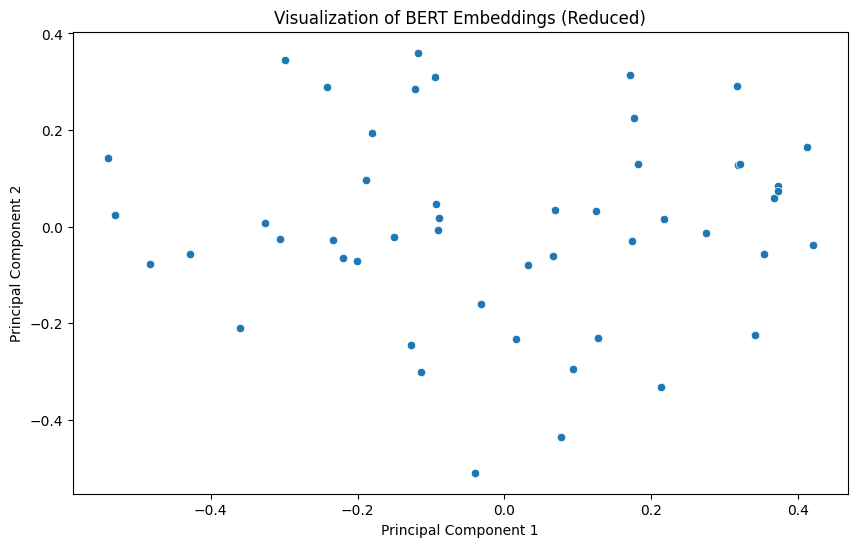

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("combined_embeddings_reduced.csv")

# Extract the first two columns for 2D visualization
data_2d = data.iloc[:, :2].values  # Select the first two components

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], data=data)
plt.title("Visualization of BERT Embeddings (Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# New Section

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
45,0.016182,-0.231734,-0.191645,-0.029933,-0.232803,0.442703,-0.039181,0.094224,0.005647,0.033564,...,-0.053545,-0.014011,0.013774,-0.043681,0.053907,0.032974,-0.020086,-0.003075,-0.005306,7.535238e-08
46,-0.180771,0.193854,-0.079624,-0.072506,-0.035128,0.095008,0.081519,0.115027,-0.194525,-0.200773,...,-0.010764,0.056983,0.017691,-0.000581,0.004209,0.059146,0.047999,-0.011957,-0.013788,7.535237e-08
47,0.274382,-0.013804,-0.146720,0.114862,-0.004565,-0.171526,0.239387,-0.024207,-0.038991,-0.020816,...,0.055012,-0.063155,-0.008119,-0.001451,-0.025963,-0.082651,-0.080216,-0.040447,0.024955,7.535223e-08
48,-0.428597,-0.055795,0.185794,-0.032686,0.053084,0.028425,0.089976,0.055520,0.002380,0.067285,...,-0.159539,-0.068547,-0.027493,0.038634,0.025387,0.003677,-0.040726,-0.015494,-0.015735,7.535231e-08
49,-0.089205,0.018067,-0.122984,-0.161953,-0.104288,0.009366,-0.109775,0.021112,-0.068632,0.271848,...,0.061561,-0.011922,-0.004377,-0.029151,-0.035480,-0.009272,0.004736,-0.006172,0.002497,7.535223e-08


# **final text classification code**

In [ ]:
from google.colab import files
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel # Remove SentenceTransformer from this import statement
from sentence_transformers import SentenceTransformer # Import SentenceTransformer from sentence_transformers
import numpy as np
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

# Step 1: Upload the dataset
uploaded = files.upload()

# Access the uploaded file (assuming it's a CSV file)
file_name = list(uploaded.keys())[0]
print(f'File uploaded: {file_name}')

# Step 2: Load the dataset into a pandas DataFrame
df = pd.read_csv(file_name, delimiter='\t', header=None, names=['text'])  # Assuming tab-delimited file

print(df.head())  # Print the first few rows of the DataFrame

# Assuming there's a column named 'text' in your dataset that contains the text data
text_data = df['text'].tolist()

# Step 3: Preprocess text data for word embeddings
sentences = [sentence.split() for sentence in text_data]

# Step 4: Train Word2Vec model (if not using pre-trained)
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Step 5: Extract word embeddings and average for each sentence
sentence_embeddings = []
for sentence in sentences:
    word_embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if word_embeddings:
        sentence_embedding = np.mean(word_embeddings, axis=0)
        sentence_embeddings.append(sentence_embedding)

# Step 6: Combine with BERT embeddings (optional)
# You might need to reinitialize this based on your requirements
model = SentenceTransformer('all-mpnet-base-v2') # Initialize sentence transformer model
bert_embeddings = model.encode(text_data, convert_to_tensor=True)

# Move bert_embeddings to CPU
bert_embeddings = bert_embeddings.cpu()

combined_embeddings = np.concatenate([sentence_embeddings, bert_embeddings], axis=1)

# Step 7: Reduce dimensionality (optional)
# Apply PCA to reduce the dimensionality of combined embeddings
pca = PCA(n_components=30)  # Adjust n_components as needed
combined_embeddings_reduced = pca.fit_transform(combined_embeddings)

# Step 8: Save the extracted features (reduced size)
embeddings_numpy = combined_embeddings_reduced  # Use the reduced combined embeddings
np.save('combined_embeddings_reduced.npy', embeddings_numpy)

# Optionally, save features as a CSV (reduced size)
df_embeddings = pd.DataFrame(embeddings_numpy)
df_embeddings.to_csv('combined_embeddings_reduced.csv', index=False)

print('Features extracted and saved successfully (reduced size).')

Saving Ses01F_impro02.txt to Ses01F_impro02 (1).txt
Saving Ses01F_impro03.txt to Ses01F_impro03 (1).txt
Saving Ses01F_impro04.txt to Ses01F_impro04 (1).txt
Saving Ses01F_impro05.txt to Ses01F_impro05 (1).txt
Saving Ses05F_impro01.txt to Ses05F_impro01.txt
File uploaded: Ses01F_impro02 (1).txt
                                                text
0  Ses01F_impro02_F000 [007.2688-016.6000]: Did y...
1                                           M: Yeah.
2  Ses01F_impro02_M000 [017.6000-020.6264]: It's ...
3  Ses01F_impro02_F001 [019.8500-022.7800]: Yeah....
4  Ses01F_impro02_M001 [021.7600-027.5558]: I don...
Features extracted and saved successfully (reduced size).


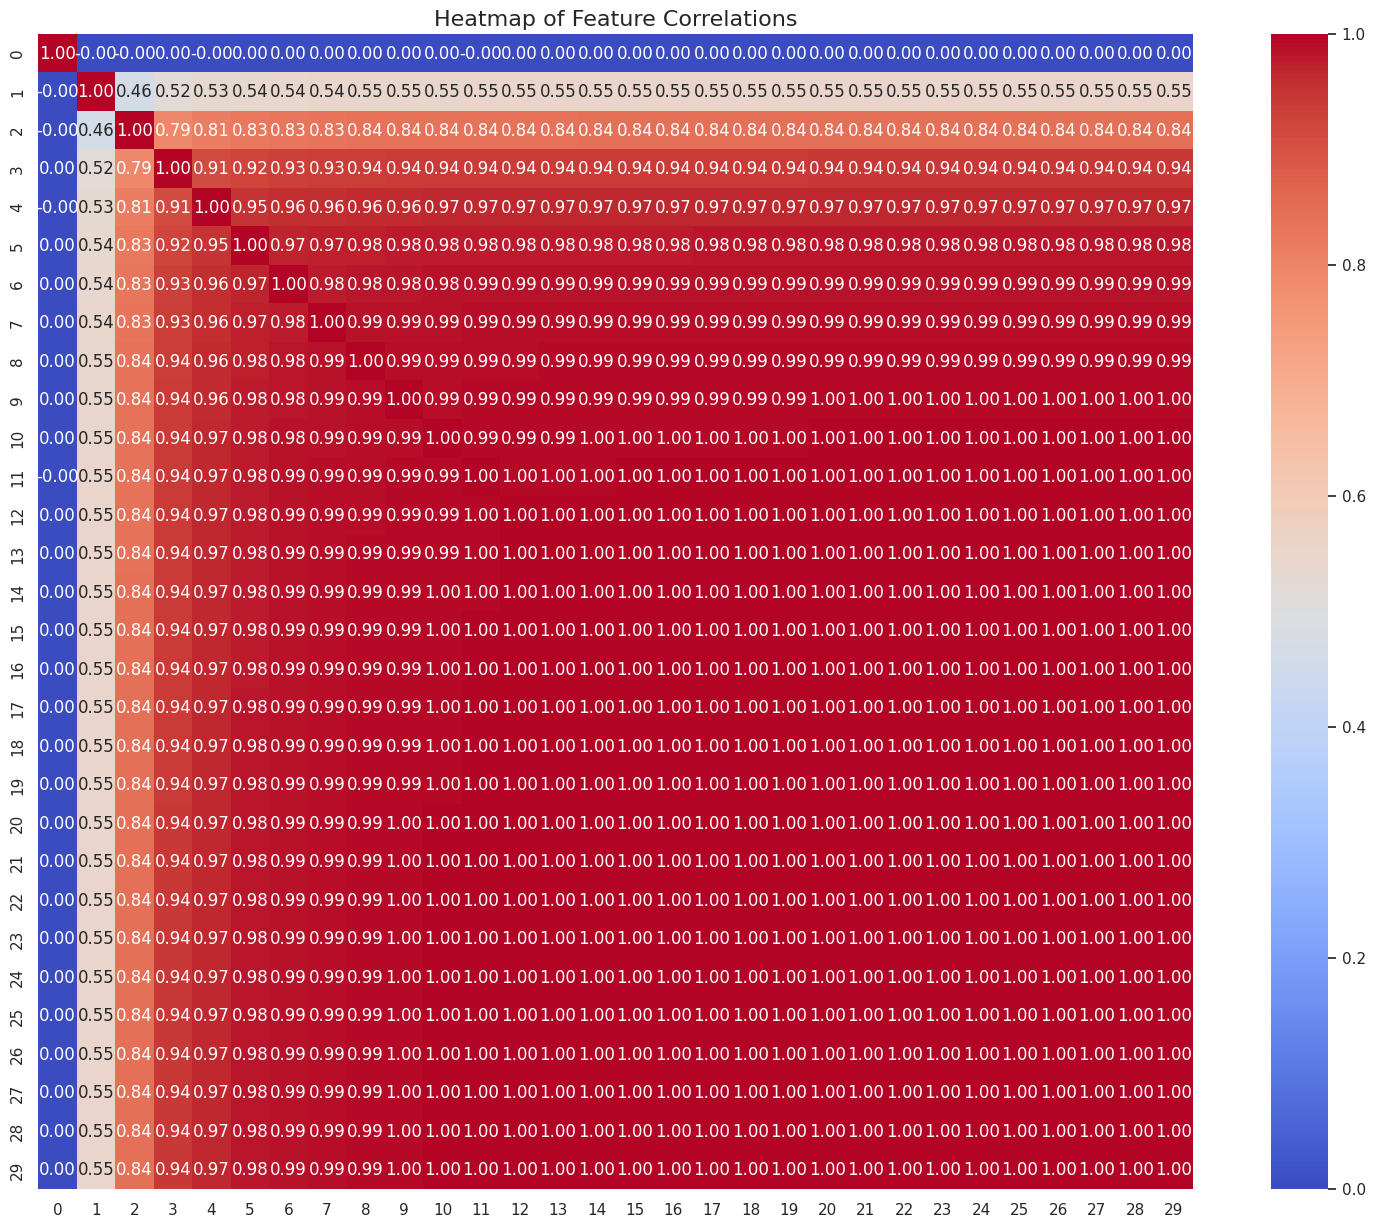

In [ ]:
# Step 1: Load the CSV data without headers
df = pd.read_csv('combined_embeddings_reduced.csv', header=None)

# Step 2: Calculate the correlation matrix
correlation_matrix = df.corr()

# Step 3: Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Step 4: Customize the plot
plt.title('Heatmap of Feature Correlations', fontsize=16)
plt.show()

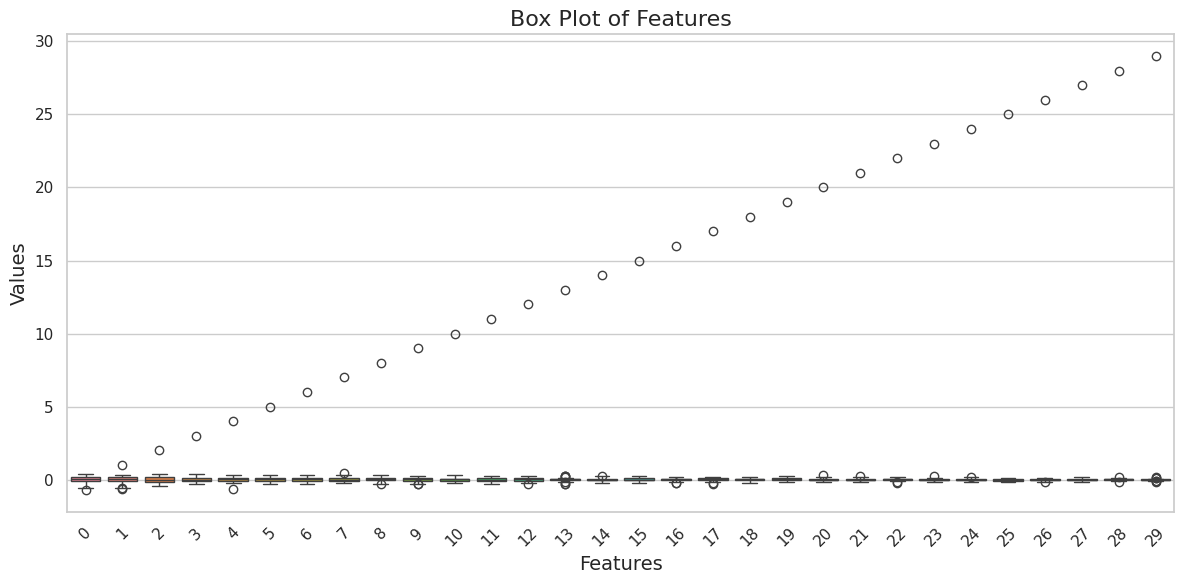

In [ ]:
# Step 1: Load the CSV data without headers
df = pd.read_csv('combined_embeddings_reduced.csv', header=None)

# Step 2: Create a box plot for all features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)

# Step 3: Customize the plot
plt.title('Box Plot of Features', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xticks(rotation=45)

# Step 4: Show the plot
plt.tight_layout()
plt.show()

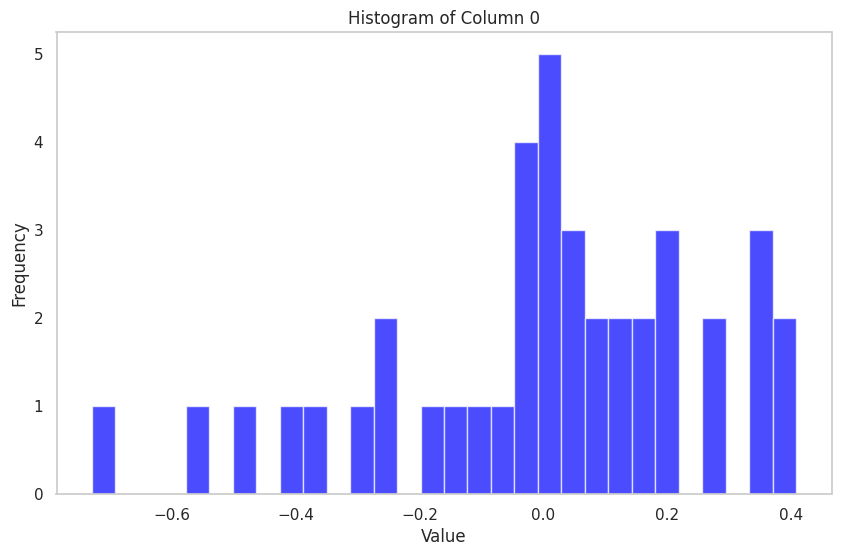

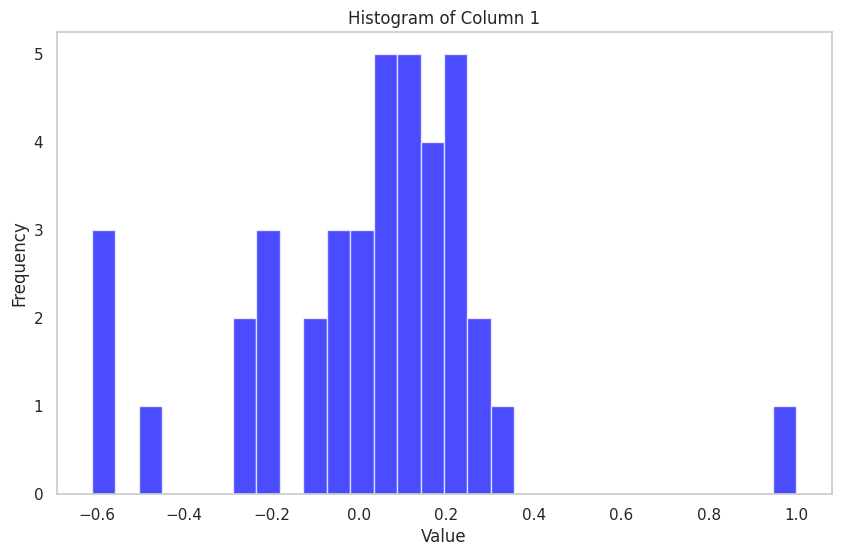

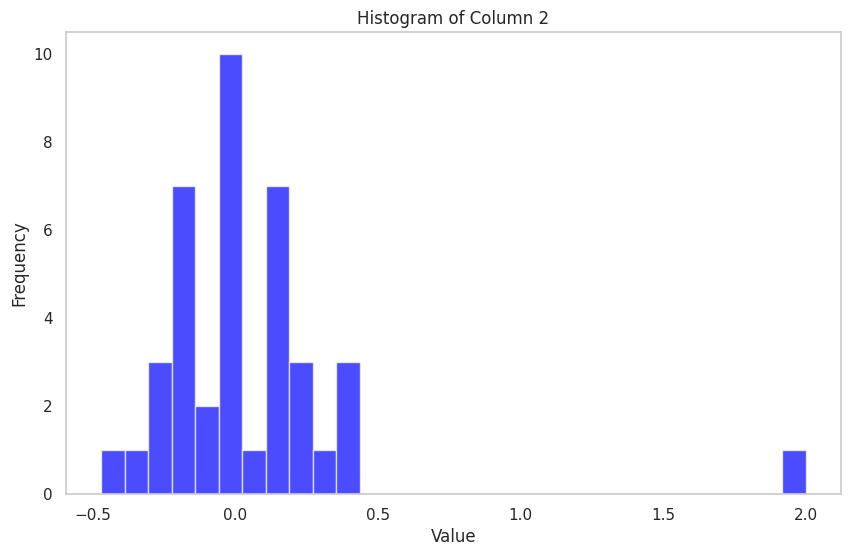

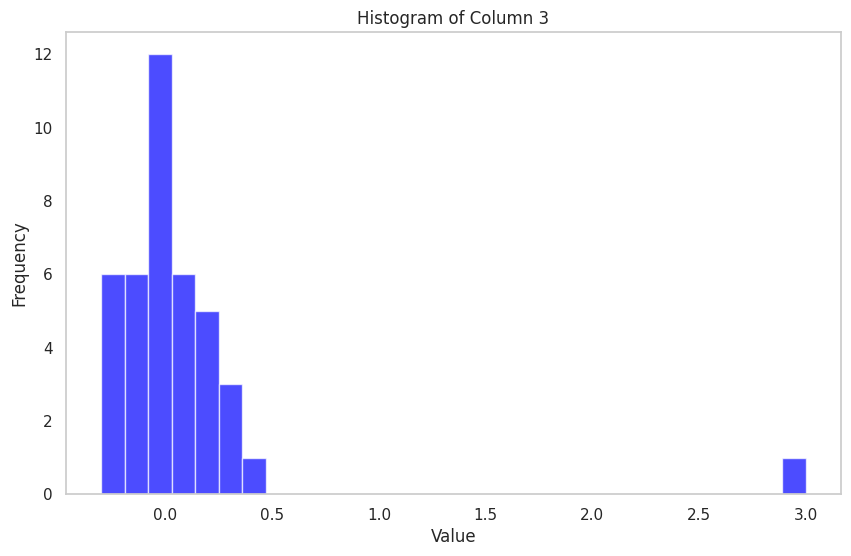

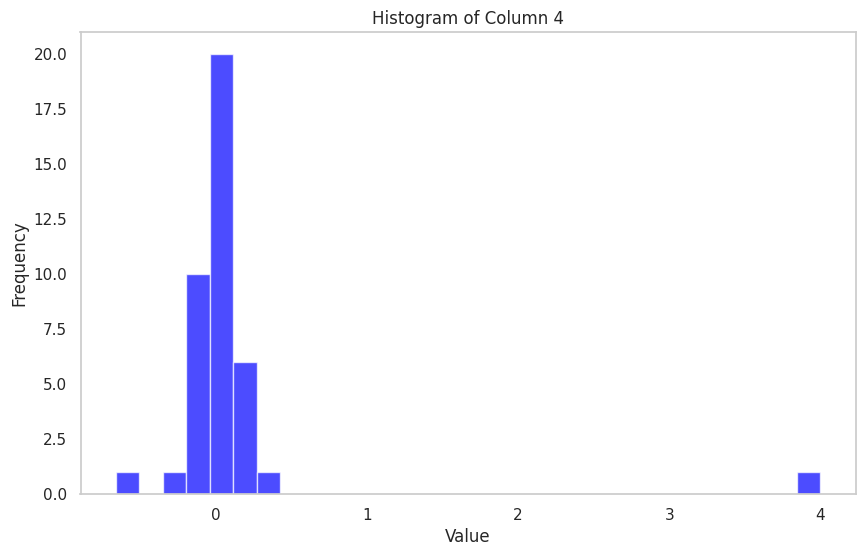

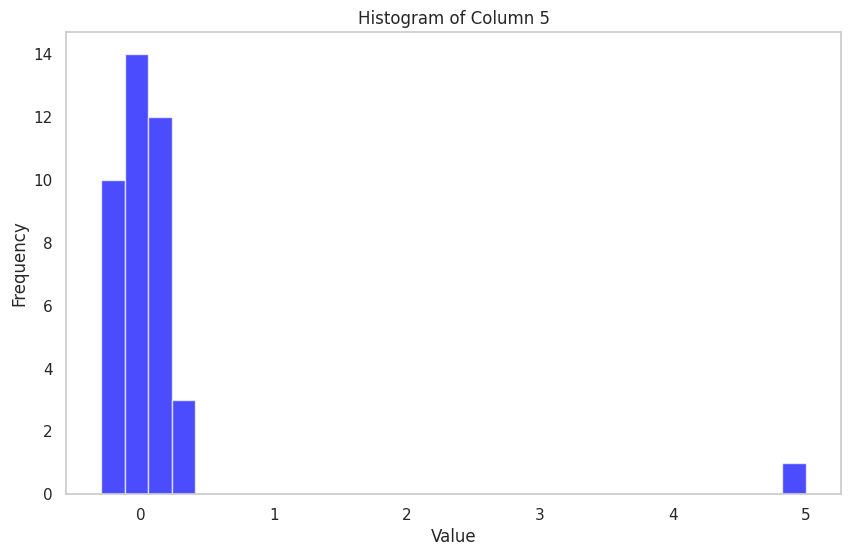

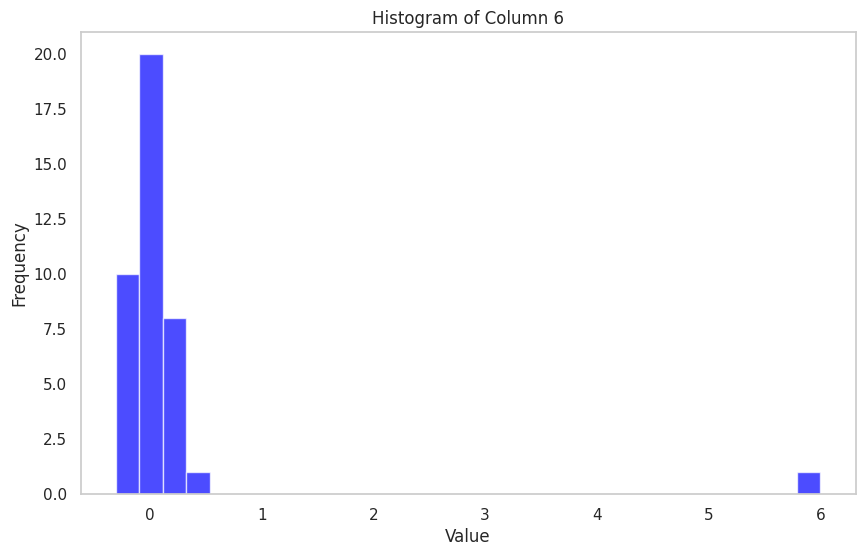

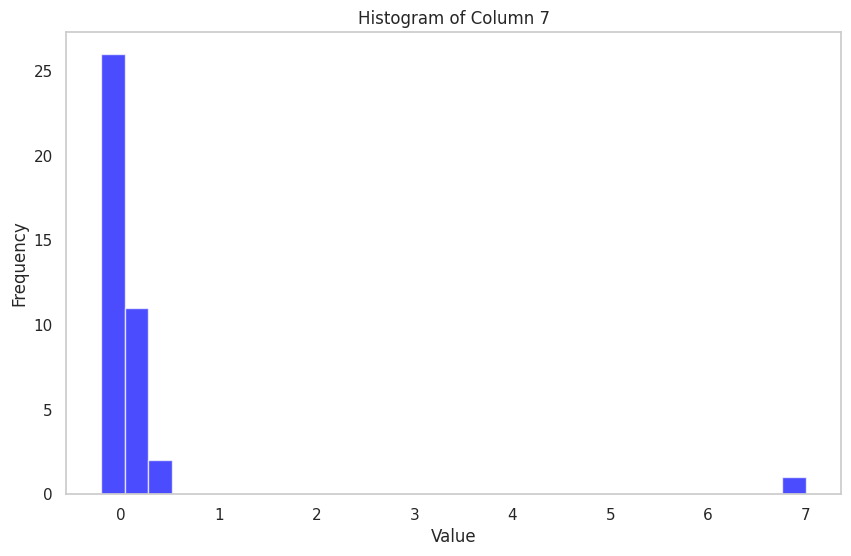

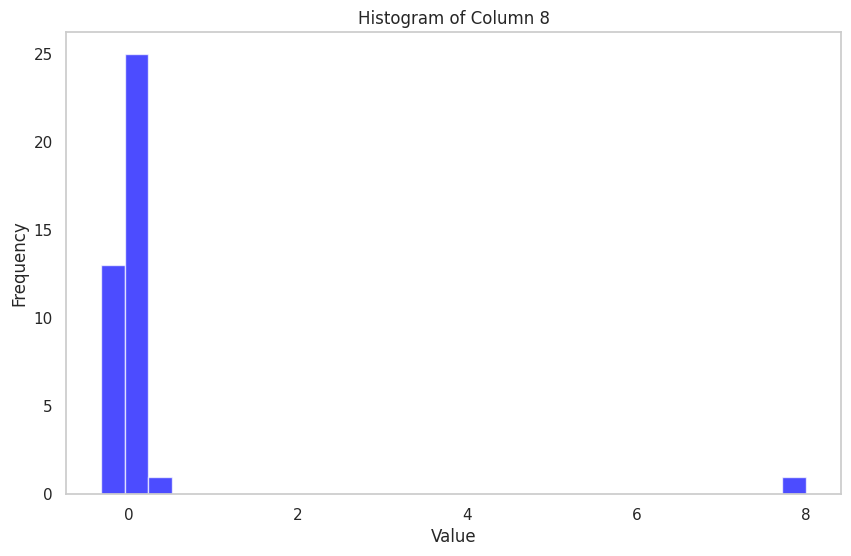

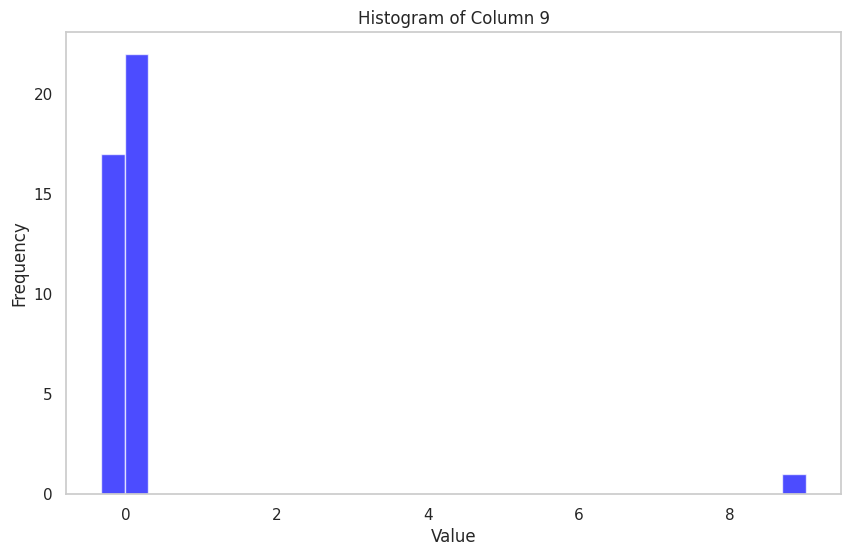

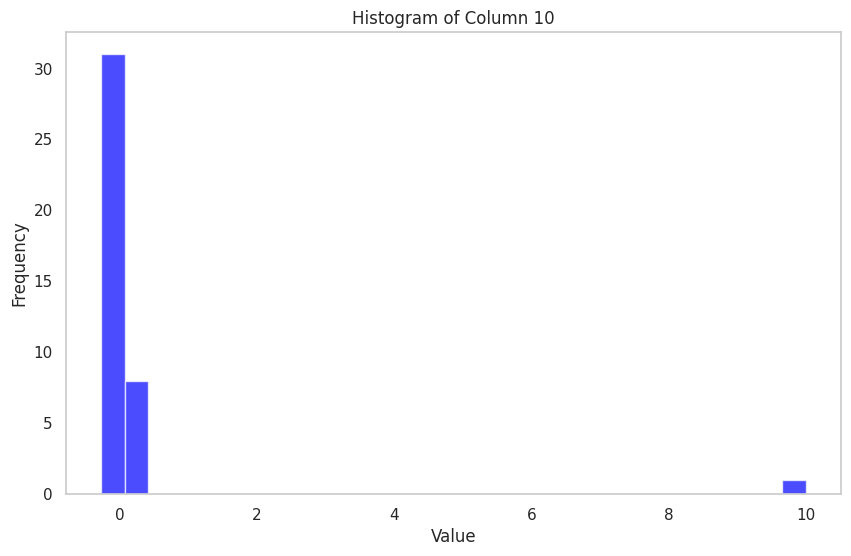

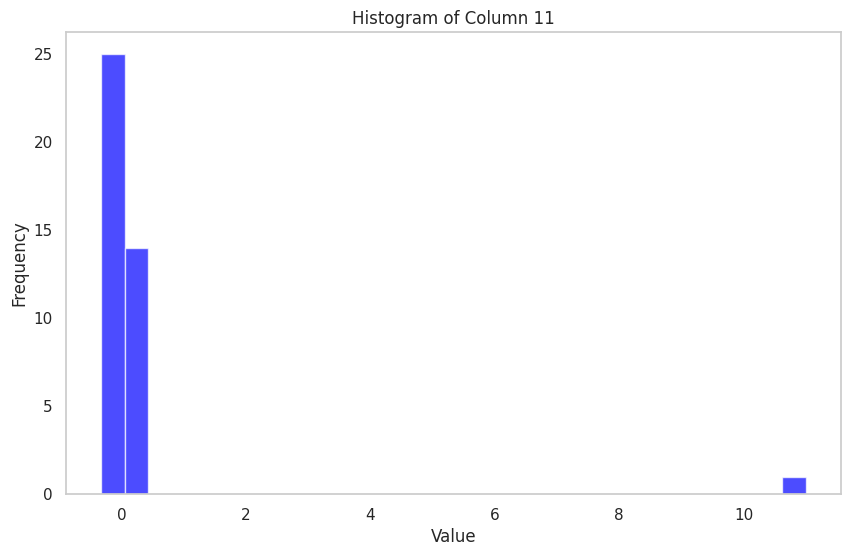

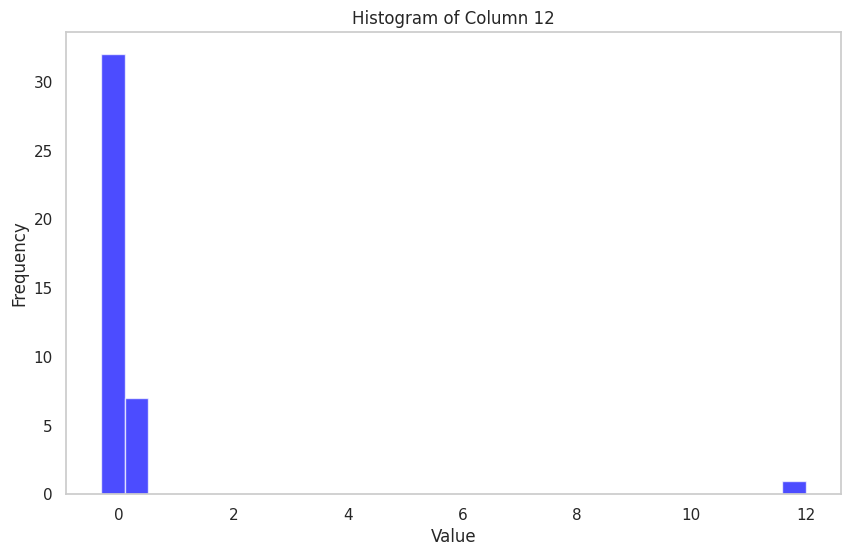

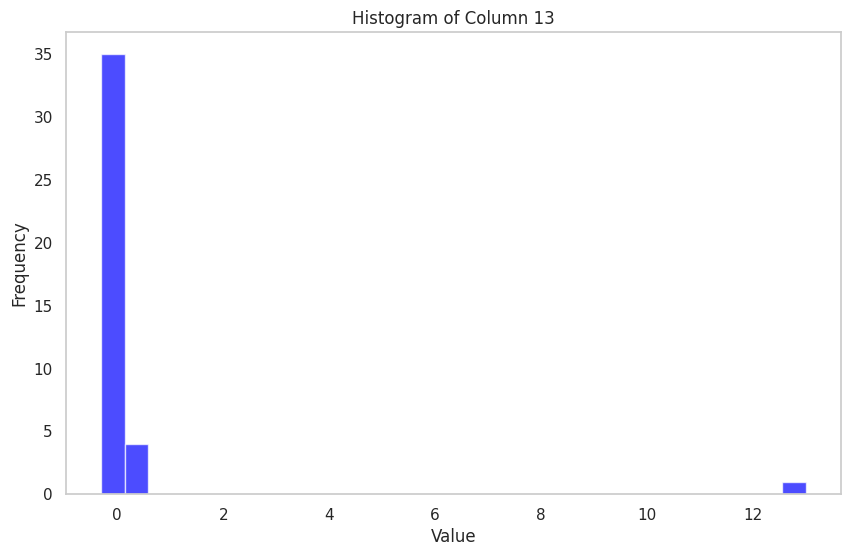

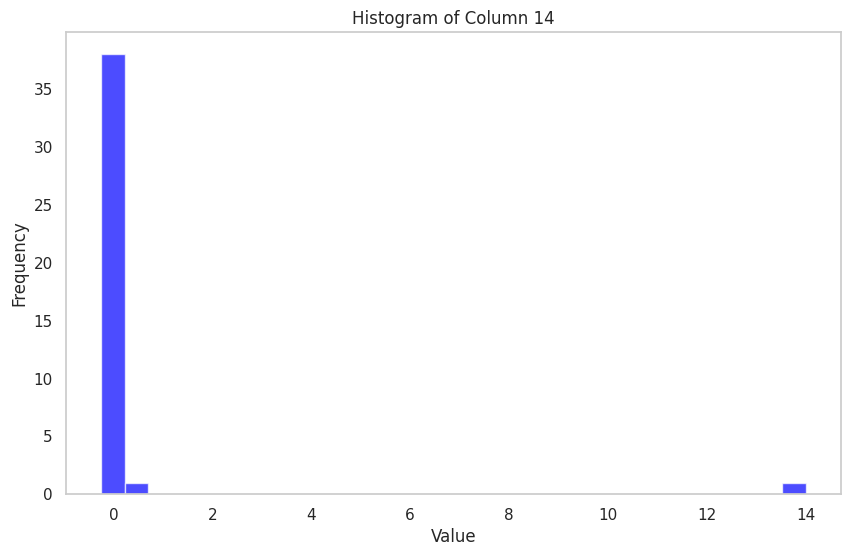

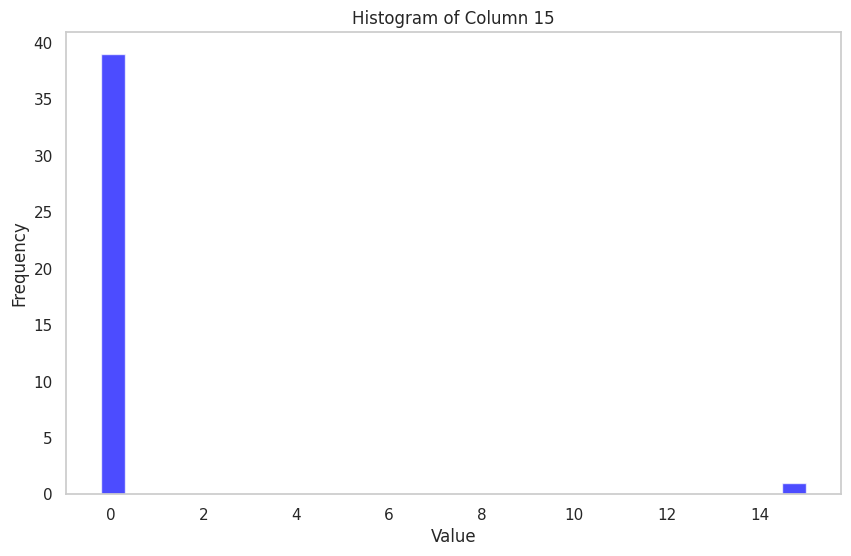

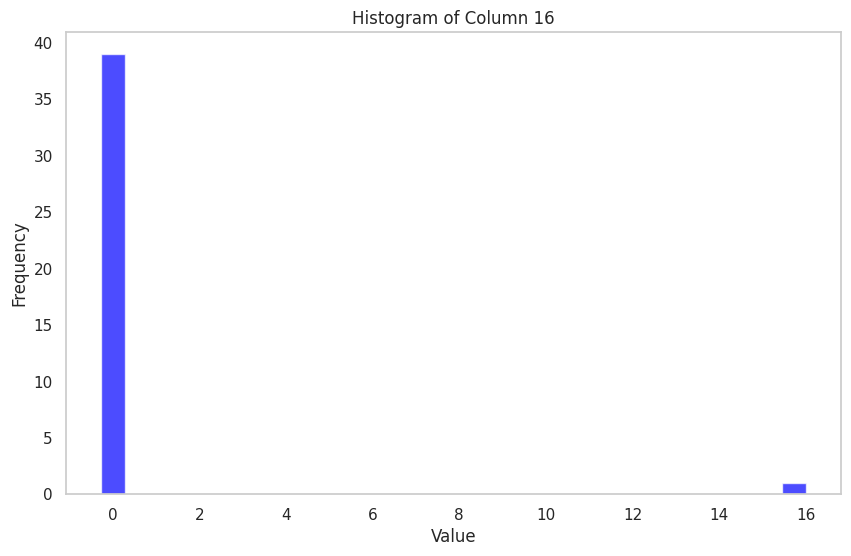

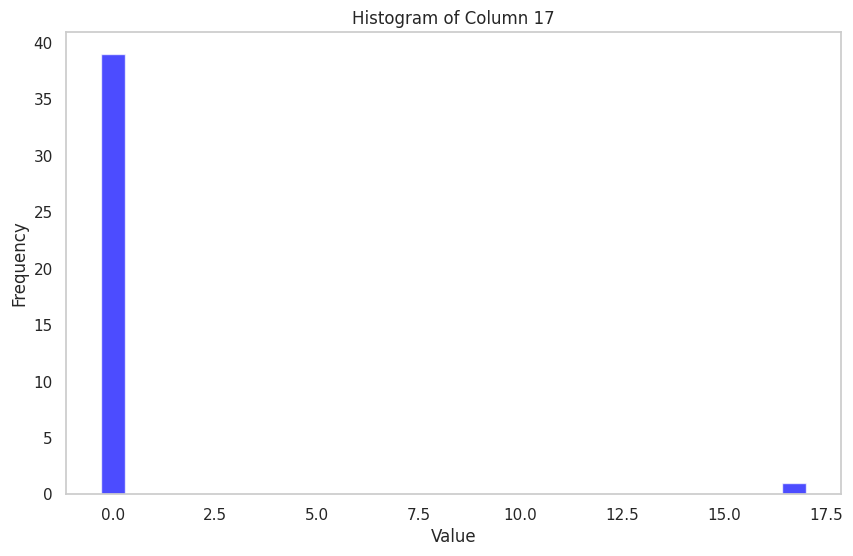

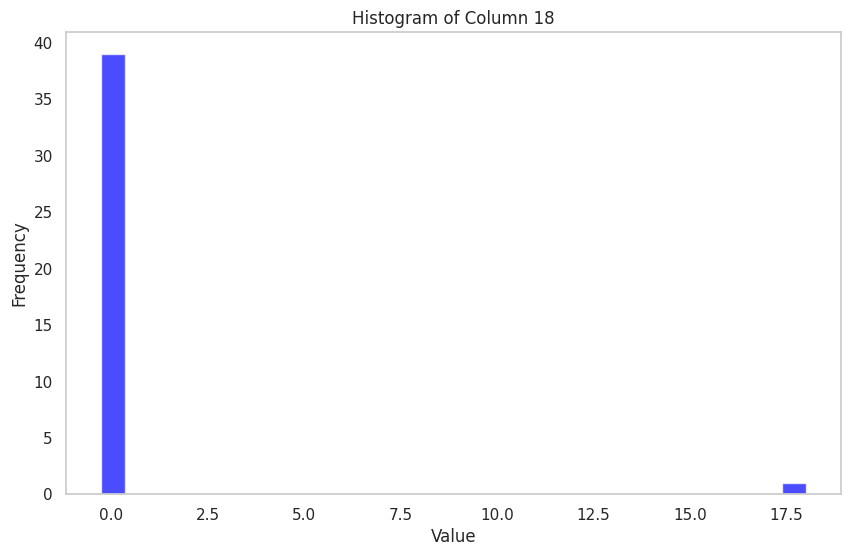

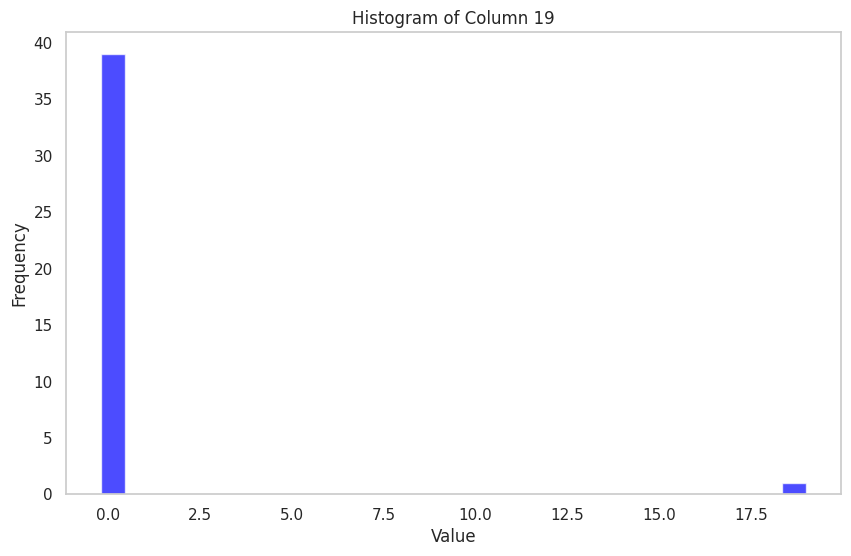

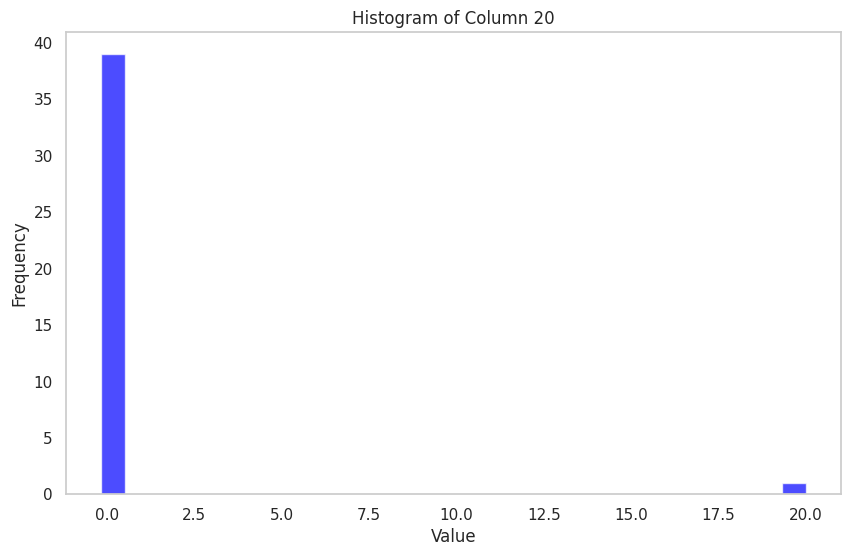

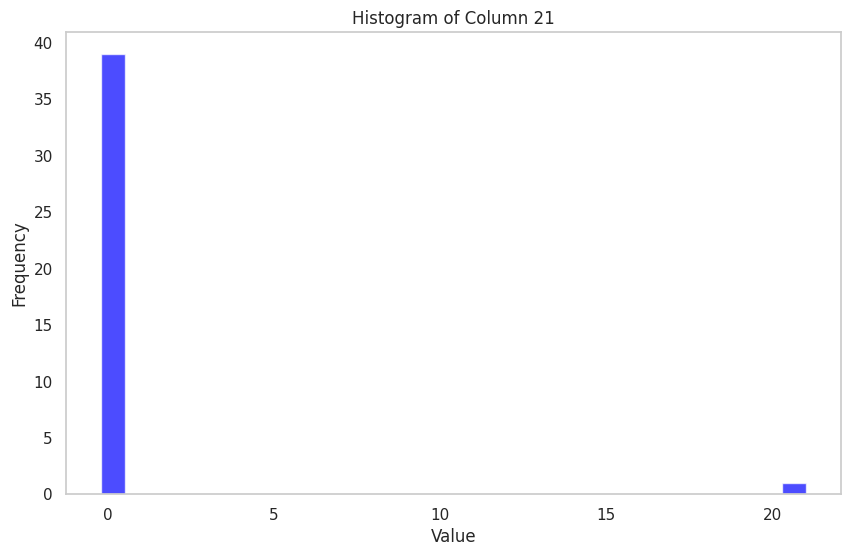

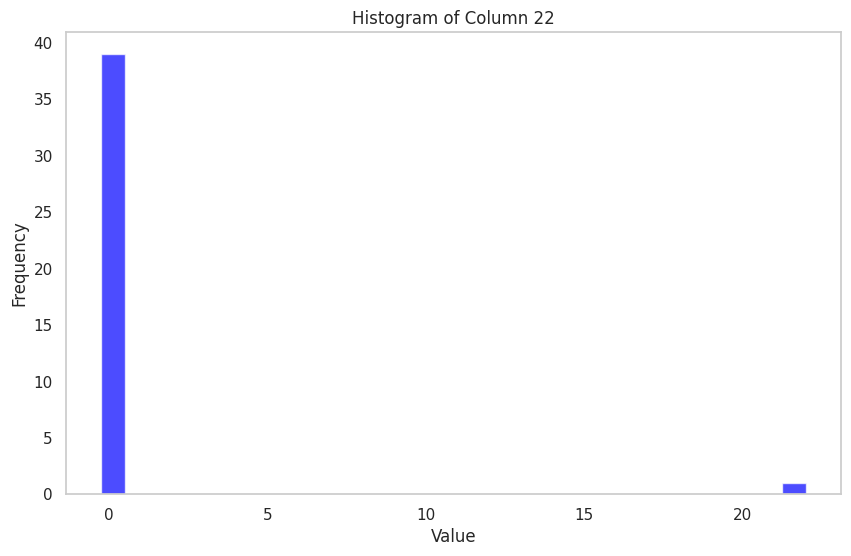

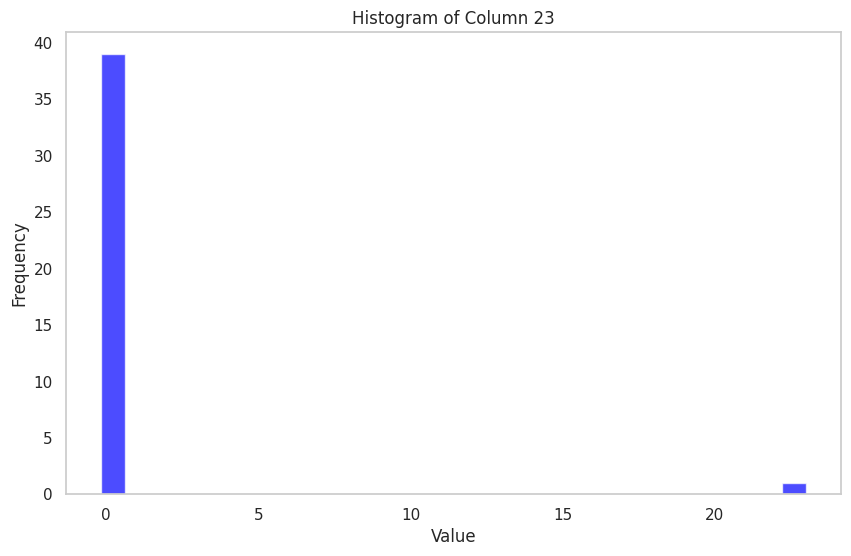

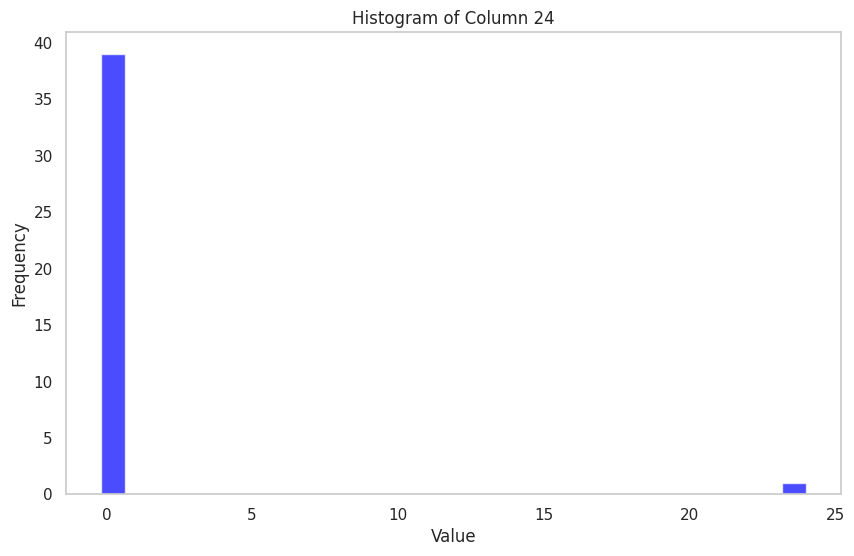

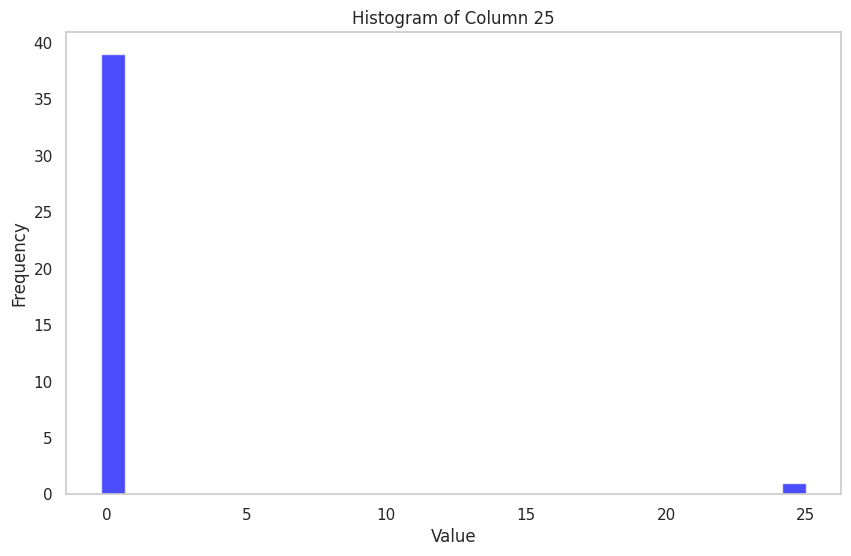

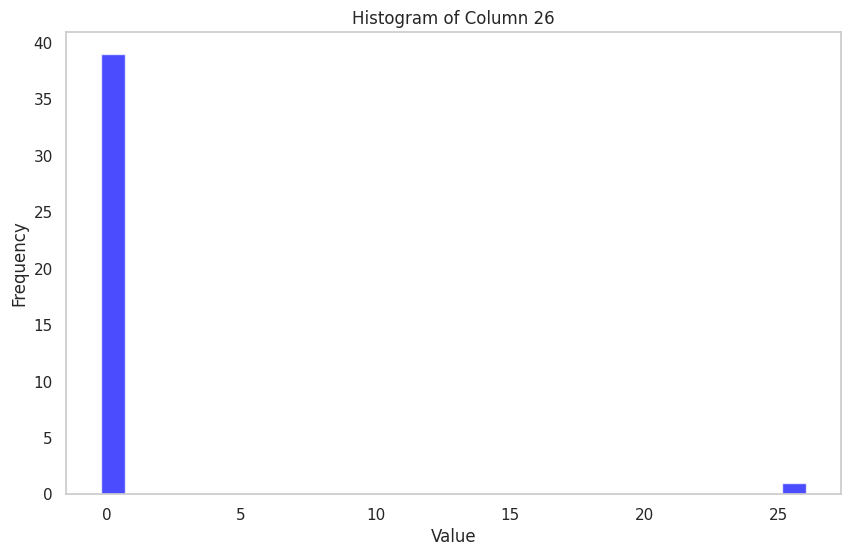

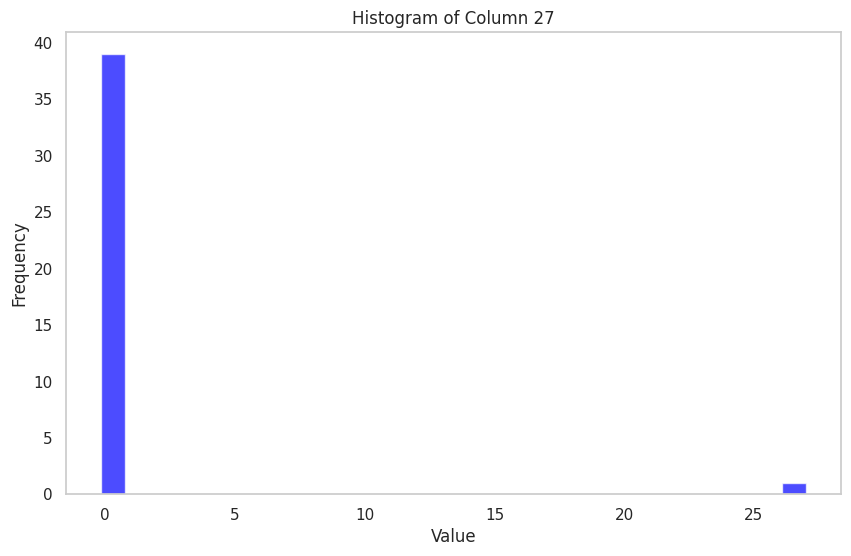

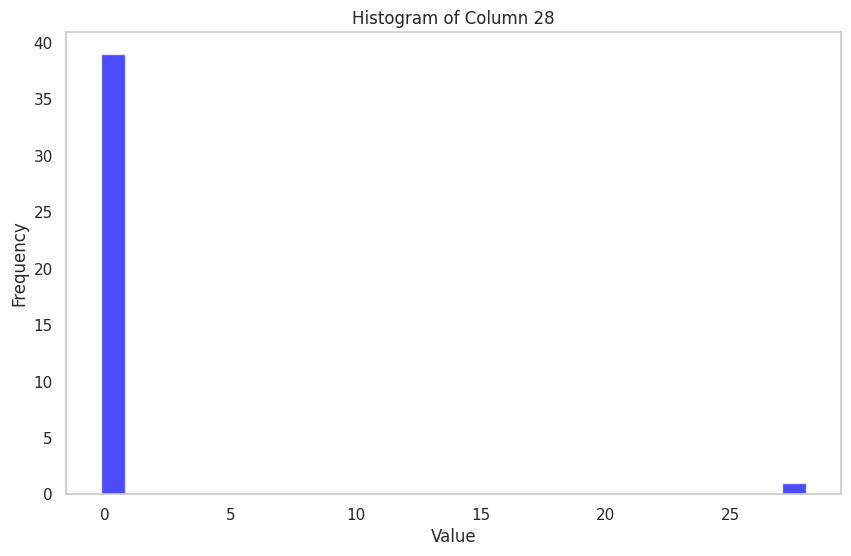

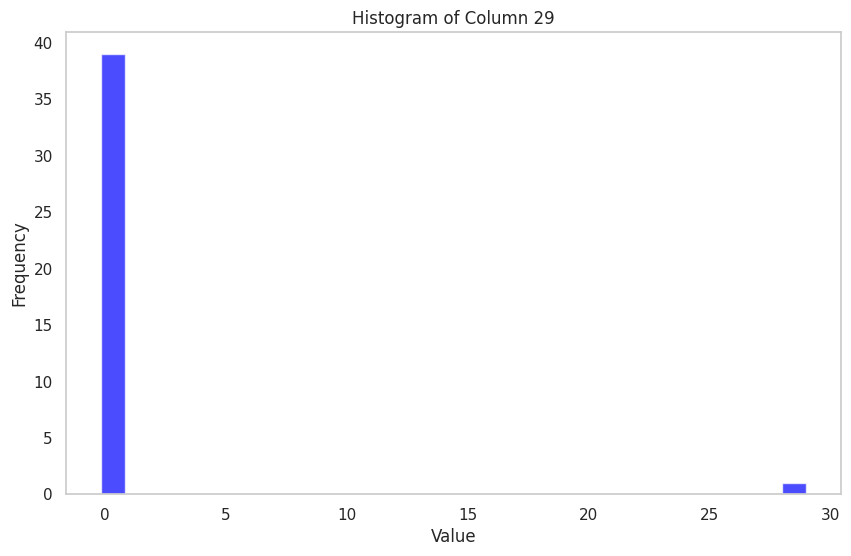

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for each numerical column
for i in range(df.shape[1]):  # Loop through each column
    plt.figure(figsize=(10, 6))
    plt.hist(df[i], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of Column {i}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("/content/combined_embeddings_reduced (1).csv")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.193371,0.236960,0.154083,0.047740,0.100892,0.305164,0.220703,-0.148245,-0.065929,0.182812,...,0.105662,-0.052223,0.005462,-0.004172,-0.068013,-0.019440,0.073169,-0.073205,0.095556,-0.095719
1,-0.354265,0.191317,0.385485,-0.024895,-0.664499,0.181504,-0.168318,0.301424,-0.281149,-0.034126,...,0.022528,0.025299,-0.006480,0.060509,-0.048721,-0.008899,-0.024312,-0.004279,0.008249,0.009593
2,0.079808,-0.557822,-0.107427,0.176665,-0.134565,0.106627,-0.000348,-0.116892,0.028977,0.001230,...,-0.023910,-0.009999,0.006802,-0.035023,-0.010377,-0.012199,-0.004861,0.075607,0.044572,0.035016
3,0.279534,0.050091,0.142837,-0.094078,-0.157404,-0.108383,0.127389,-0.002138,0.115060,-0.008178,...,-0.106603,-0.024248,0.010769,-0.032963,-0.018384,-0.100544,0.022042,0.117154,0.022382,0.012022
4,0.055040,0.039673,0.205261,-0.120681,0.130358,-0.091590,0.036035,-0.057905,0.106712,0.078267,...,-0.107020,-0.061869,0.100684,0.238426,0.096178,-0.136159,0.032168,-0.082447,0.032135,0.156332


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the data
data = pd.read_csv('/content/combined_embeddings_reduced (1).csv')

# Assuming the features are in the DataFrame
X = data.values  # Convert to numpy array if necessary

# Perform KMeans clustering
n_clusters = 3  # Choose a number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Evaluate clustering quality
silhouette_avg = silhouette_score(X, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.04


Silhouette Score: 0.09
Silhouette Score: 0.04
Silhouette Score: -0.00
Silhouette Score: 0.02
Silhouette Score: 0.03
Silhouette Score: 0.06
Silhouette Score: 0.10
Silhouette Score: 0.10


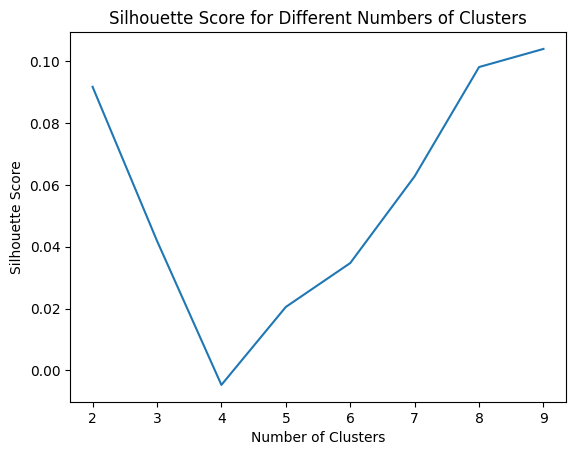

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
cluster_range = range(2, 10)  # Try different cluster sizes

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f'Silhouette Score: {silhouette_avg:.2f}')

plt.plot(cluster_range, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

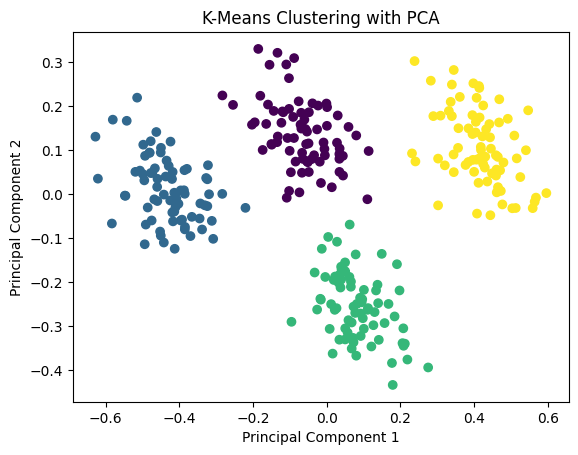

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering with PCA')
plt.show()

Silhouette Score: 0.66


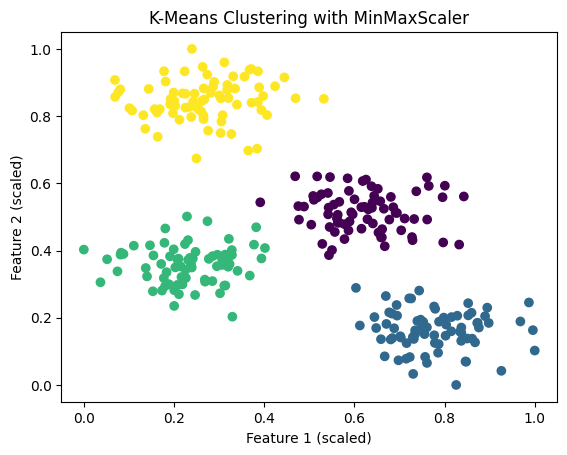

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create synthetic data
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Visualize the clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering with MinMaxScaler')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.show()